In [1]:
import sagemaker
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()


In [2]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sagemaker_session.boto_region_name, 'image-classification', repo_version="latest")
print (training_image)

433757028032.dkr.ecr.us-west-2.amazonaws.com/image-classification:latest


In [3]:
s3_output_location = 's3://sagemaker-container-webinar/'
ic = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sagemaker_session)

In [4]:
ic.set_hyperparameters(num_layers=50,
                             image_shape = "3,32,32",
                             num_classes=10,
                             num_training_samples=50000,
                             mini_batch_size=256,
                             epochs=10,
                             learning_rate=0.01,
                             precision_dtype='float32')

In [5]:
train_path = 's3://sagemaker-container-webinar/cifar10-recordio/train'
val_path = 's3://sagemaker-container-webinar/cifar10-recordio/validation'

train_data = sagemaker.session.s3_input(train_path, distribution='FullyReplicated', 
                        content_type='application/x-recordio', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(val_path, distribution='FullyReplicated', 
                             content_type='application/x-recordio', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data}

In [6]:
ic.fit(inputs=data_channels, logs=True)

2019-08-20 04:36:28 Starting - Starting the training job...
2019-08-20 04:36:30 Starting - Launching requested ML instances.........
2019-08-20 04:38:03 Starting - Preparing the instances for training...
2019-08-20 04:38:57 Downloading - Downloading input data
2019-08-20 04:38:57 Training - Downloading the training image........
Docker entrypoint called with argument(s): train
[08/20/2019 04:40:08 INFO 139967452378944] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype': u'float32', u'mini_batch_size': 32, u'weight_decay': 0.0001, u'learning_rate': 0.1, u'momentum': 0}
[08/20/2019 04:40:08 INFO 139967452378944] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'learnin

In [7]:
predictor = ic.deploy(initial_instance_count = 1, instance_type = 'ml.c5.large')

---------------------------------------------------------------------------------------!

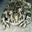

sample-img/1009_frog.png


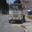

sample-img/1008_truck.png


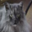

sample-img/1014_cat.png


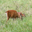

sample-img/1003_deer.png


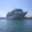

sample-img/1004_ship.png


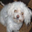

sample-img/1000_dog.png


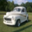

sample-img/1005_automobile.png


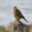

sample-img/1038_bird.png


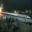

sample-img/1001_airplane.png


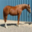

sample-img/1037_horse.png


In [41]:
from IPython.display import Image, display
import os
import numpy as np
import json

labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
images = []
for entry in os.scandir('sample-img'):
    if entry.is_file() and entry.name.endswith("png"):
        images.append('sample-img/' + entry.name)

for image in images:
    display(Image(image))
    print(image)

In [44]:
predictor.content_type = 'application/x-image'
predictor.serializer = None

labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

def get_prediction(file_path):
    
    with open(file_path, "rb") as image:
        f = image.read()
    b = bytearray(f)
    pred = json.loads(predictor.predict(b))
    return labels[np.argmax(pred)]

In [62]:
predictions = [get_prediction(image) for image in images]

print('Predictions','\t\t\t','Actual')
for pred, actual in zip(predictions,images):
    print(pred,'    \t',actual)

Predictions 			 Actual
horse     	 sample-img/1009_frog.png
truck     	 sample-img/1008_truck.png
cat     	 sample-img/1014_cat.png
deer     	 sample-img/1003_deer.png
airplane     	 sample-img/1004_ship.png
dog     	 sample-img/1000_dog.png
automobile     	 sample-img/1005_automobile.png
bird     	 sample-img/1038_bird.png
airplane     	 sample-img/1001_airplane.png
horse     	 sample-img/1037_horse.png


In [ ]:
ic.delete_endpoint()